# This is a second order wave equation with Dirichlet boundary conditions used to test different minimizers. 

We just implement the wave equation as a toy model to try different minimizers and strategies. 

Let's solve this 1-dimensional wave equation:

```math
\begin{align*}
∂^2_t u(x, t) = c^2 ∂^2_x u(x, t) \quad & \textsf{for all } 0 < x < 1 \text{ and } t > 0 \, , \\
u(0, t) = u(1, t) = 0 \quad & \textsf{for all } t > 0 \, , \\
u(x, 0) = x (1-x)     \quad & \textsf{for all } 0 < x < 1 \, , \\
∂_t u(x, 0) = 0       \quad & \textsf{for all } 0 < x < 1 \, , \\
\end{align*}
```

with grid discretization `dx = 0.1` and physics-informed neural networks.

Further, the solution of this equation with the given boundary conditions is presented.


In [ ]:
using NeuralPDE, Lux, LuxCUDA, Optimization, OptimizationOptimJL
using ModelingToolkit, IntervalSets, Plots, JLD2

@parameters t, x
@variables u(..)
Dxx = Differential(x)^2
Dtt = Differential(t)^2
Dt = Differential(t)

#2D PDE
C = 1
eq = Dtt(u(t, x)) ~ C^2 * Dxx(u(t, x))

# Initial and boundary conditions
bcs = [u(t, 0) ~ 0.0,# for all t > 0
    u(t, 1) ~ 0.0,# for all t > 0
    u(0, x) ~ x * (1.0 - x), #for all 0 < x < 1
    Dt(u(0, x)) ~ 0.0] #for all  0 < x < 1]

# Space and time domains
ti = 0.0
tf = 1.0
xi = 0.0
xf = 1.0
domains = [t ∈ Interval(ti, tf),
    x ∈ Interval(xi, xf)]
# Discretization
dx = 0.1

@named wave = PDESystem(eq, bcs, domains, [t, x], [u(t, x)])

# Neural network
chain = Chain(Dense(2, 16, σ), Dense(16, 16, σ), Dense(16, 1))


#strategy = QuadratureTraining(; abstol = 1e-6, reltol = 1e-6, batch = 200)
strategy = GridTraining(0.05)
discretization = PhysicsInformedNN(chain, strategy#, param_estim = true
#, additional_loss = additional_loss
)

prob = discretize(wave, discretization)

sym_prob = symbolic_discretize(wave, discretization)

pde_inner_loss_functions = sym_prob.loss_functions.pde_loss_functions
bcs_inner_loss_functions = sym_prob.loss_functions.bc_loss_functions

loss = Float64[]
callback = function (p, l)
    push!(loss, l)
    println("loss: ", l)
    println("pde_losses: ", map(l_ -> l_(p.u), pde_inner_loss_functions))
    println("bcs_losses: ", map(l_ -> l_(p.u), bcs_inner_loss_functions))
    return false
end
discretization = PhysicsInformedNN(chain, GridTraining(dx))

@named pde_system = PDESystem(eq, bcs, domains, [t, x], [u(t, x)])
prob = discretize(pde_system, discretization)



OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [0.06978846341371536 -0.24860943853855133; 0.06769641488790512 0.8186484575271606; … ; 0.5510061979293823 -0.4111250042915344; 0.5191870331764221 1.14875328540802], bias = [0.04470314085483551, 0.02971234731376171, 0.214452862739563, -0.007131331134587526, 0.052023373544216156, -0.23606273531913757, 0.6332013607025146, -0.646455705165863, 0.5633326768875122, -0.3426569998264313, 0.46535009145736694, -0.25955480337142944, 0.6899292469024658, 0.5373924374580383, 0.5487061142921448, 0.39234569668769836]), layer_2 = (weight = [-0.28999993205070496 0.16791576147079468 … -0.2558366656303406 0.29518476128578186; 0.4095102548599243 0.4042341411113739 … -0.34510165452957153 -0.21763582527637482; … ; 0.15852241218090057 0.20595121383666992 … 0.4179568290710449 0.2494657337665558; -0.13833433389663696 -0.2799326479434967 … -0.119416743516922 -0.04553009197115898], bias = [-0.05604761838912964, -0.0069440305233001

In [3]:

opt = OptimizationOptimJL.BFGS()
res = Optimization.solve(prob, opt; callback, maxiters = 1200)
phi = discretization.phi

loss: 0.46948561316022097
pde_losses: [0.00020242164226830342]
bcs_losses: [0.11755626011821553, 0.0928285707031445, 0.26378652757236154, 0.002367157314379711]
loss: 0.05562922520256082
pde_losses: [0.00014834961284095546]
bcs_losses: [0.015250802860535725, 0.028891511148287665, 0.008362831091249202, 0.002355539814220346]
loss: 0.02987051364845435
pde_losses: [0.00012554634928766312]
bcs_losses: [0.0011615815215997181, 0.00521444433697017, 0.022824759067286544, 0.0014275990226151694]
loss: 0.022083482097354626
pde_losses: [1.5101779144288623e-5]
bcs_losses: [0.0027134167242711866, 0.003947813968384797, 0.015136018657653127, 0.0005797052091006777]
loss: 0.021515594281772348
pde_losses: [9.649995993293318e-6]
bcs_losses: [0.001746153121412033, 0.0022682530323910894, 0.01680844644179273, 0.001133141733326315]
loss: 0.021483256415590655
pde_losses: [8.14062537584509e-6]
bcs_losses: [0.0019280804142348504, 0.002277386587822846, 0.01624163845180704, 0.0014261133082481914]
loss: 0.02137165536

NeuralPDE.Phi{StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}(StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}(Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static

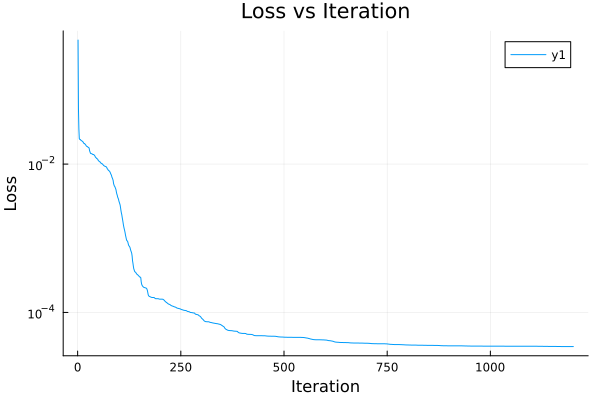

In [4]:
using Plots

plot(loss, yscale=:log10, xlabel="Iteration", ylabel="Loss", title="Loss vs Iteration"  )

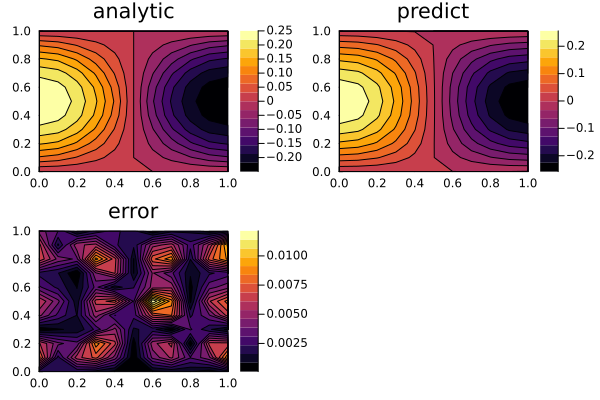

In [5]:
#using Plots

ts = ti:dx:tf
xs = xi:dx:xf
function analytic_sol_func(t, x)
    sum([(8 / (k^3 * pi^3)) * sin(k * pi * x) * cos(C * k * pi * t) for k in 1:2:50000])
end

u_predict = reshape([first(phi([t, x], res.u)) for t in ts for x in xs],
    (length(ts), length(xs)))
u_real = reshape([analytic_sol_func(t, x) for t in ts for x in xs],
    (length(ts), length(xs)))

diff_u = abs.(u_predict .- u_real)
p1 = plot(ts, xs, u_real, linetype = :contourf, title = "analytic");
p2 = plot(ts, xs, u_predict, linetype = :contourf, title = "predict");
p3 = plot(ts, xs, diff_u, linetype = :contourf, title = "error");
plot(p1, p2, p3)
